# Introducción:
    
## Descripcción data

• fullVisitorId: Identificador único del visitante.

• channelGrouping: Canal de agrupación (ej. orgánico, pagado, etc.).

• weekend_prop: Proporción de visitas durante el fin de semana.

• hour: Hora de la visita.

• sessionId: Identificador de la sesión

• device.browser: Navegador del dispositivo.

• device.deviceCategory: Categoría del dispositivo (desktop, móvil, tablet).

• device.isMobile: Indica si el dispositivo es móvil.

• device.operatingSystem: Sistema operativo del dispositivo.

• totals.hits: Total de hits (interacciones) en la sesión.

• totals.pageviews: Total de páginas vistas en la sesión.

• bounce_prop: Proporción de rebotes.

• trafficSource.medium: Medio de tráfico (orgánico, referenciado, etc.)

## Tareas

Análisis Exploratorio de Datos (EDA)

Preprocesamiento de Datos

Segmentación de Clientes

Análisis e Interpretación de Resultados


In [1]:
import plotly.io as pio
pio.renderers.default = "jpg"

import os
os.environ['OMP_NUM_THREADS'] = "1"
# import libraries

# the basic ones
import numpy as np
import pandas as pd

# Model
from sklearn.ensemble import RandomForestRegressor

# pipeline and column trasnformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputing numerical data
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# we will use this one (for categorical columns) to lower the amount of columns and work a little faster
from sklearn.preprocessing import TargetEncoder

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# To plot clusters in lower dimension
from sklearn.manifold import TSNE

# new library, we haven't used this one before in this repo
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score

# Entendiendo la Data
(paso previo a EDA)

In [2]:
np.random.seed(0)

In [3]:
X = pd.read_csv('data_customers.csv') # , index_col='fullVisitorId'

In [4]:
X.head()

,fullVisitorId,channelGrouping,weekend_prop,hour,sessionId,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium
0,213131142648941,Direct,0.000000,22.0,1,Chrome,desktop,0.0,Macintosh,14.0,13.0,0.0,(none)
1,435324061339869,Referral,0.666667,21.0,3,Chrome,desktop,0.0,Macintosh,14.0,11.0,0.0,referral
2,562678147042735,Organic Search,0.000000,14.0,2,Chrome,desktop,0.0,Macintosh,12.5,10.5,0.0,organic
3,585708896049892,Referral,0.000000,20.0,1,Chrome,desktop,0.0,Linux,22.0,20.0,0.0,referral
4,670722016498267,Referral,0.000000,17.0,2,Chrome,desktop,0.0,Linux,9.5,9.5,0.0,referral


In [5]:
X.shape

(9996, 13)

Son pocos datos por lo que podríamos usar un GMM en lugar de un Kmeans. GMM es más flexible a la hora de encontrar grupos o cluster. En particular, permite encontrar cluster no esfericos lo que puede ser muy interesante. 

In [6]:
X.dtypes 

fullVisitorId              uint64
channelGrouping            object
weekend_prop              float64
hour                      float64
sessionId                   int64
device.browser             object
device.deviceCategory      object
device.isMobile           float64
device.operatingSystem     object
totals.hits               float64
totals.pageviews          float64
bounce_prop               float64
trafficSource.medium       object
dtype: object

In [7]:
str(X.fullVisitorId.dtypes)

'uint64'

In [8]:
X.columns

Index(['fullVisitorId', 'channelGrouping', 'weekend_prop', 'hour', 'sessionId',
       'device.browser', 'device.deviceCategory', 'device.isMobile',
       'device.operatingSystem', 'totals.hits', 'totals.pageviews',
       'bounce_prop', 'trafficSource.medium'],
      dtype='object')

In [9]:
X.describe()

,fullVisitorId,weekend_prop,hour,sessionId,device.isMobile,totals.hits,totals.pageviews,bounce_prop
count,9.996000e+03,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,4.478856e+18,0.147011,14.449030,3.606443,0.096870,22.177771,17.530312,0.082718
std,3.066153e+18,0.296219,6.261204,6.074226,0.295655,21.916773,16.259149,0.162298
min,2.131311e+14,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,1.577139e+18,0.000000,11.000000,1.000000,0.000000,9.000000,8.000000,0.000000
50%,4.346933e+18,0.000000,16.500000,2.000000,0.000000,17.000000,14.000000,0.000000
75%,7.132082e+18,0.126359,19.000000,4.000000,0.000000,28.000000,22.500000,0.083333
max,9.998996e+18,1.000000,23.000000,278.000000,1.000000,500.000000,466.000000,0.925373


Temas interesantes **weekend_prop** es una probabilidad, en general es baja la participación de visita los fin de semana. Probablemente sea porque es un sitio vinculado al trabajo (?).

A mi en particular me gusta esta simple tabla ya que se pueden ver outliers (unidimensionales) comparando el 75% percentil y el máximo. Ya que si la diferencia es mucha probablemente haya que indagar más aquí. Columnas que habrá que revisar en este respecto son:
+ sessionId
+ totals.hits
+ totals.pageviews

Tengo dudas con sessionId por lo que la exploraremos un poco aquí. 
La duda puntual es si efectivamente el fullVisitorId es único, o será que hay usuarios que navegan más de una vez con distintas sesiones? 

In [10]:
X.sessionId.unique()

array([  1,   3,   2,   8,   7,  16,   6,   5,   4,   9,  12,  13,  11,
        18,  14,  22,  28,  15,  19,  10, 135,  20,  17,  25,  31,  44,
        21,  26,  23,  65,  32,  33,  40,  24,  35,  29, 278,  45,  30,
       106,  37, 155, 200, 129,  38,  34,  81,  39,  57,  27,  83, 148,
        86,  41], dtype=int64)

In [11]:
len(list(X.fullVisitorId.unique()))

9996

perfecto fullVisitorId es único!

In [12]:
X.isnull().any() 

fullVisitorId             False
channelGrouping           False
weekend_prop              False
hour                      False
sessionId                 False
device.browser            False
device.deviceCategory     False
device.isMobile           False
device.operatingSystem    False
totals.hits               False
totals.pageviews          False
bounce_prop               False
trafficSource.medium      False
dtype: bool

Tampocos tenemos nulos!

# EDA + Limpieza datos

Se explorará mucho rápido y luego se extraerá lo mejor ;)

## Cuando y cómo nos visitan los usuarios

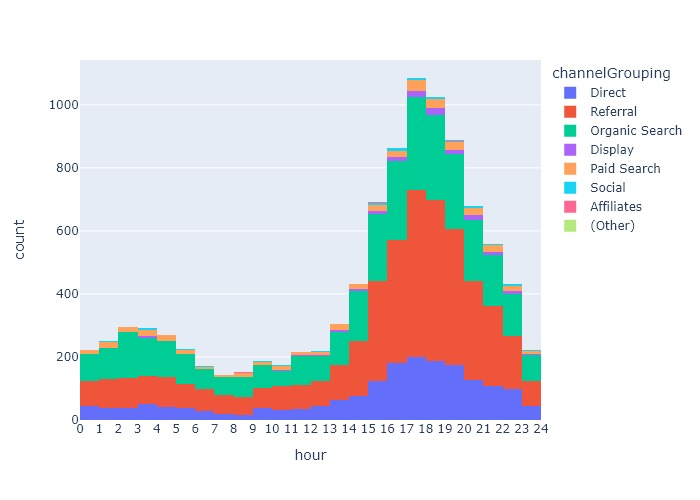

In [13]:
fig = px.histogram(X, x="hour",nbins=24, color="channelGrouping")
fig.update_xaxes(tickmode='linear', dtick=1)
fig.show()

En general los usuarios nos vistitan pasado las 14hrs hasta las 23hrs, con peak cercano a las 18hrs. Y estos llegar siendo referidos (es decir, haciendo clicks en otras páginas a la nuestra).

In [14]:
# esta variable es necesaria para algunos análisis posteriores, luego de usarla se borrará. 
# básicamente es para contar cada fila como 1 y sirve para contar registros similares
# en alguna métrica
X['numero_usuarios_1'] = 1

In [15]:
total = X.numero_usuarios_1.sum()
tráfico_14_23_hrs = X[(X['hour']>14) & (X['hour']<23)].numero_usuarios_1.sum()
print(f"El tráfico entre las 14 y 23 hrs ({23-14} horas) corresponda al {round(tráfico_14_23_hrs/total,2)*100}%")

El tráfico entre las 14 y 23 hrs (9 horas) corresponda al 63.0%


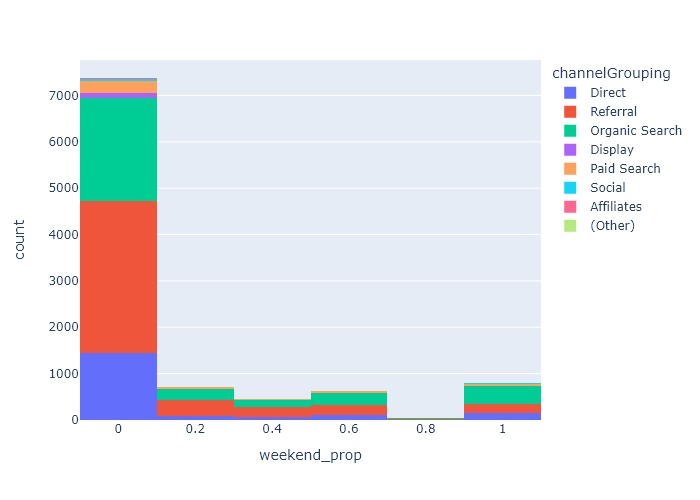

In [16]:
# % que trabaja en la semana 
fig = px.histogram(X, x="weekend_prop",nbins=10, color="channelGrouping")
fig.update_xaxes(tickmode='linear', dtick=0.2)
fig.show()

En general los usuarios navegan en los días de semana.

## De donde nos ven y cómo se comportan

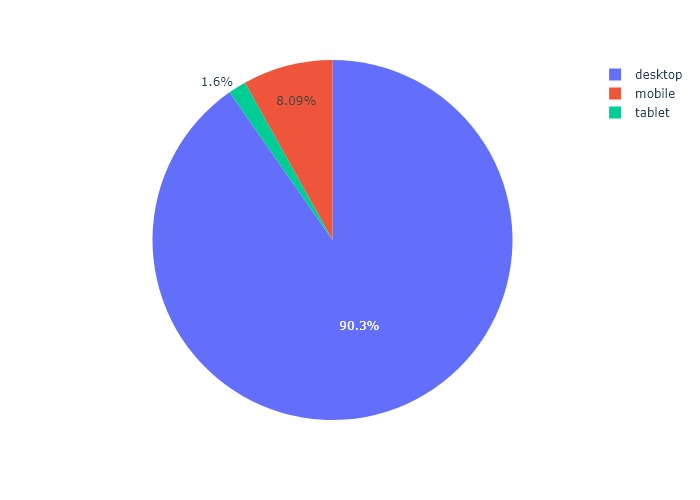

In [17]:
fig = px.pie(X, values='numero_usuarios_1', names='device.deviceCategory')
fig.show()

Nos ven generalmente del computador.

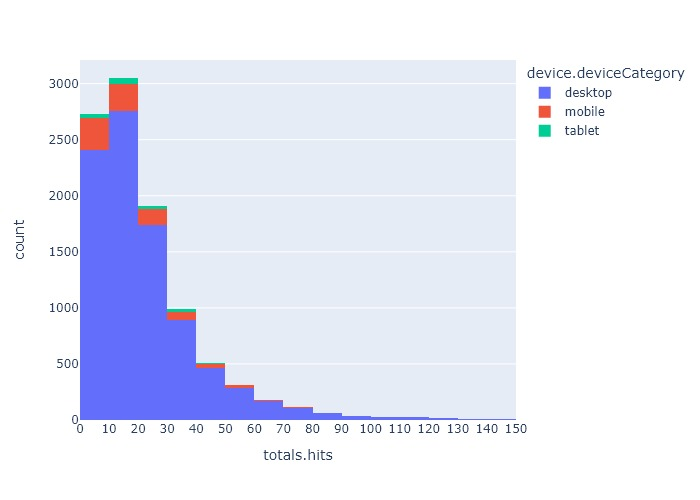

In [18]:
fig = px.histogram(X[X["totals.hits"]<150], x="totals.hits",nbins=15, color="device.deviceCategory")
fig.update_xaxes(tickmode='linear', dtick=10)
fig.show()

Hay ciertos outliers que cambian la escala del gráfico por ende tomamos arbitrariamente el limite de 150. Al parecer no hay mucha correlación entre dispositivo y el número de interacciones. Esto se verá más de cerca viendo las correlaciones más adelante.

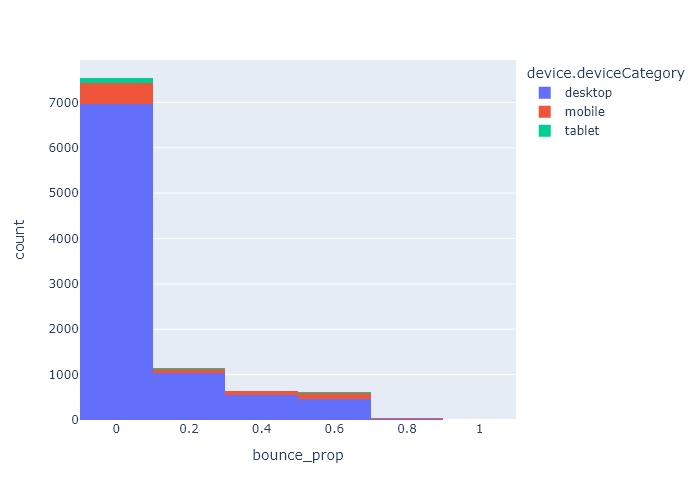

In [19]:
# rebote 
fig = px.histogram(X, x="bounce_prop",nbins=8, color="device.deviceCategory")
fig.update_xaxes(tickmode='linear', dtick=0.2)
fig.show()

En general si llegan al sitio no es un accidente, ya que se suelen quedar en este (no tienen mayor rebote).

## Caracterización inicial usuarios

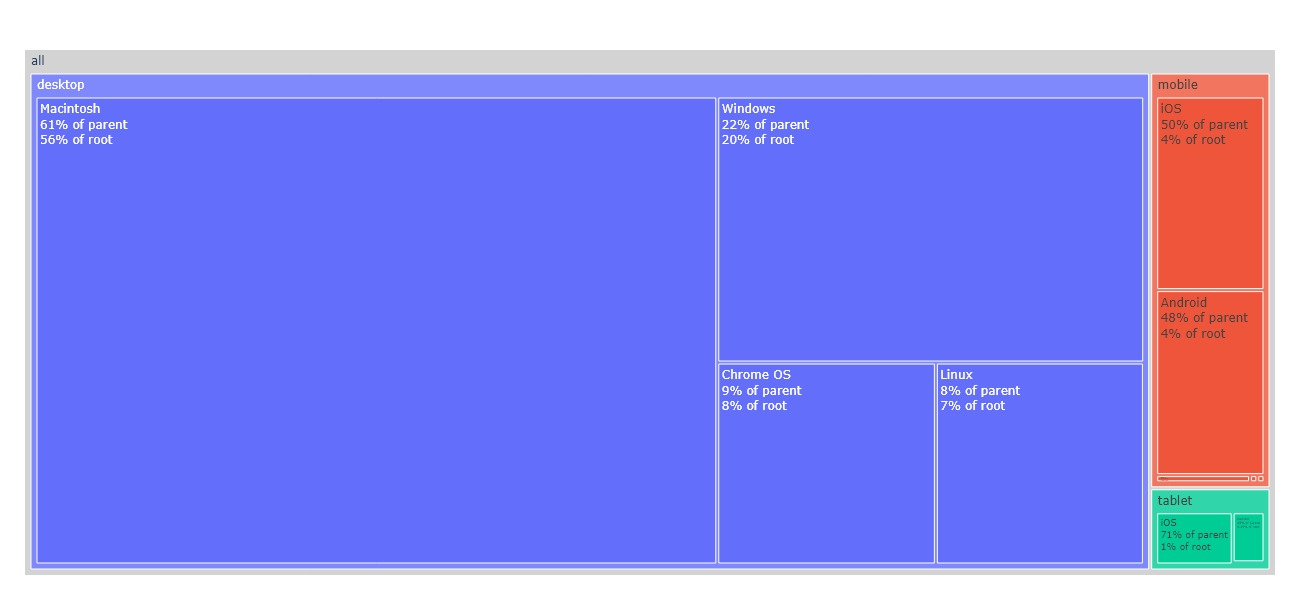

In [20]:
fig = px.treemap(X, path=[px.Constant("all"),'device.deviceCategory' ,'device.operatingSystem'], 
                 values='numero_usuarios_1', width=1300, height=600)
fig.update_traces(root_color="lightgrey" ,textinfo = "label+percent parent+percent root")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

El 56 % de todos los navegantes usan macintosh (por ende usan desktop). Es importante tener esta caracterización ya que es importantísimo que nuestro sitio web funcione correctamente para estos usuarios

# Primera caracterización de los clientes

Antes de encontrar nuestras cluster de clientes usando modelos matemáticos, es necesario tener una visión general de nuestro usuario típico que navega la plataforma, y ya sabemos harto de este.

Nuestro usuario promedio ingresa generalmente **referido** a nuestra plataforma entre las **14 hasta las 23 hrs los días de semana usando su computadora macintosh**. Una vez que entra no sale inmediatemente (bajo usuarios con rebote) Navega un poco (menos de 20 interacciones en el sitio) y termina su viaje de cliente.

## Outliers

In [21]:
X.channelGrouping.unique()

array(['Direct', 'Referral', 'Organic Search', 'Display', 'Paid Search',
       'Social', 'Affiliates', '(Other)'], dtype=object)

totals.hits


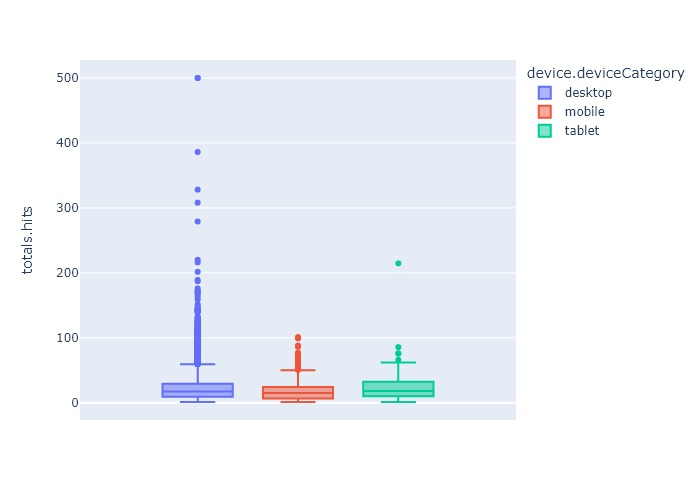

totals.pageviews


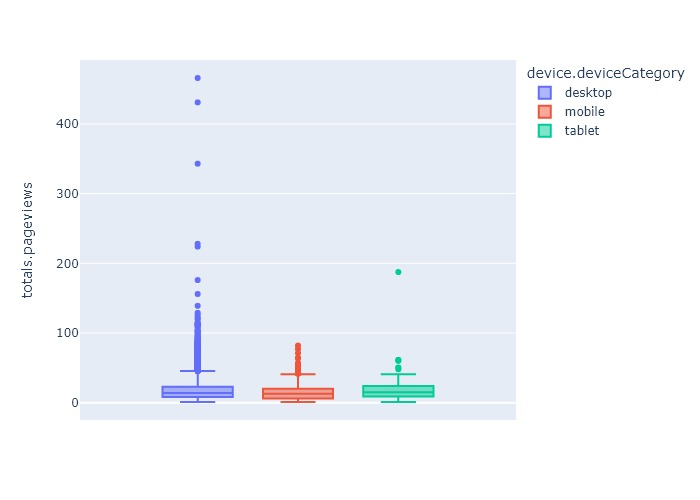

In [22]:
posibles_outliers = ["totals.hits","totals.pageviews"]
for outlier in posibles_outliers:
    print(outlier)
    fig = px.box(X, y=outlier, color="device.deviceCategory")
    fig.show()

Pese a tener outliers estos permiten "ver" la data sin distorcionar los gráficos, **se mantendrán por mientras.**

In [23]:
# notemos que valores sobre 110 son muy pocos
round((X[X["totals.hits"]>150].fullVisitorId.count()/X.fullVisitorId.count())*100,3)
# son de hecho un 0.21% mucho menos que un 1%!!! Estos registros se quitarán para que no causen distorsión en nuestros clusters

0.21

In [24]:
# con este código abajo se quitan outliers
# X = X[X["totals.hits"]>150]

In [25]:
X['device.deviceCategory'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [26]:
# Feature engineer

# crearemos una nueva columna que tendrá mucho sentido...

X['movilidad_dispositivo'] = X['device.deviceCategory']
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: -1 if str(x)=='desktop' else x)
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: 0 if str(x)=='tablet' else x)
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].apply(lambda x: 1 if str(x)=='mobile' else x)

In [27]:
X.movilidad_dispositivo.unique()

array([-1,  1,  0], dtype=int64)

In [28]:
X['movilidad_dispositivo'] = X['movilidad_dispositivo'].astype('int64')

In [29]:
numerical_col = [col for col in X.columns if str(X[col].dtypes) in ['float64','int64']]

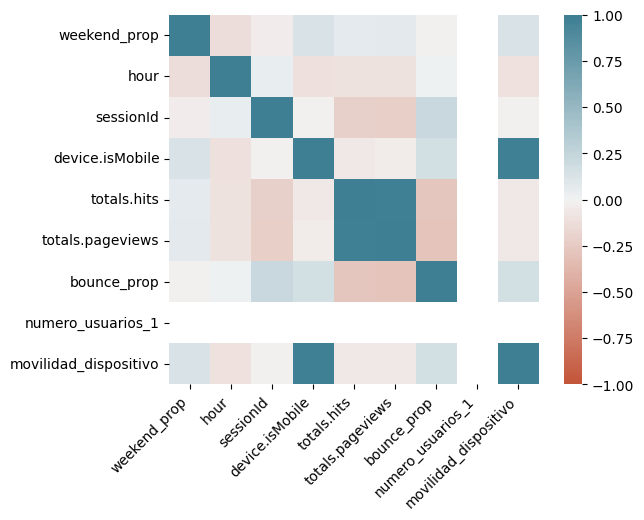

In [30]:
# mapa correlación
corr = X[numerical_col].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

En general no sé nota ninguna correlación sorprendente, la relación más grande es entre total hits y pageviews cuya relación es casi 1. Probablemente pinchar una nueva página cuenta como un hits, por ende se observa esta correlación casi 1 positiva.

La nueva variable que tenemos tiene correlación casi 1 con ismobile, pero dejaremos la de nosotros ya que sabemos exactamente que significa. De todas formas está variable será escalada para usar GMM.

In [31]:
X.drop(['device.deviceCategory','device.isMobile'], axis=1, inplace=True)

In [32]:
# sessionId tampoco añade valor así que se sacará
X.drop(['sessionId'], axis=1, inplace=True)

In [33]:
X.set_index(['fullVisitorId'])

,channelGrouping,weekend_prop,hour,device.browser,device.operatingSystem,totals.hits,totals.pageviews,bounce_prop,trafficSource.medium,numero_usuarios_1,movilidad_dispositivo
fullVisitorId,,,,,,,,,,,
213131142648941,Direct,0.000000,22.0,Chrome,Macintosh,14.0,13.0,0.0,(none),1,-1
435324061339869,Referral,0.666667,21.0,Chrome,Macintosh,14.0,11.0,0.0,referral,1,-1
562678147042735,Organic Search,0.000000,14.0,Chrome,Macintosh,12.5,10.5,0.0,organic,1,-1
585708896049892,Referral,0.000000,20.0,Chrome,Linux,22.0,20.0,0.0,referral,1,-1
670722016498267,Referral,0.000000,17.0,Chrome,Linux,9.5,9.5,0.0,referral,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
9991633376050115277,Social,0.000000,0.0,Chrome,Linux,17.0,16.0,0.0,referral,1,-1
9994767073213036303,Organic Search,0.000000,20.0,Chrome,Windows,42.0,30.0,0.0,organic,1,-1
9997409246962677759,Referral,0.000000,2.0,Chrome,Macintosh,86.0,65.0,0.0,referral,1,-1


La mayoría de los usuarios usan Macitosh. Ahora indagando un poco más notamos que en general los usuarios tienden a entrar por "referido" o por "Búsqueda orgánica". El mayor grupo se encuentra en usuarios referidos con Macitosh con un 31% del total.
Notemos solo viendo este gráficos que hay grupos más similares a otros respecto a cómo llegan al sitio web. Los de Macitosh, linux, chrome OS son similares ya que estran más por ser referidos. Ahora Windows, IOS y Android entran más por búsqueda organica.

Se podría hacer esto mismo usando la hora, y definiendo periodos día, tarde y noche. Y así ver que características tienen los usuarios que navegan de noche. Pero ahora haremos la Pipeline para ya segmentar

In [34]:
X['channelGrouping'].unique()

array(['Direct', 'Referral', 'Organic Search', 'Display', 'Paid Search',
       'Social', 'Affiliates', '(Other)'], dtype=object)

In [35]:
X['trafficSource.medium'].unique()

array(['(none)', 'referral', 'organic', 'cpm', 'cpc', 'affiliate',
       '(not set)'], dtype=object)

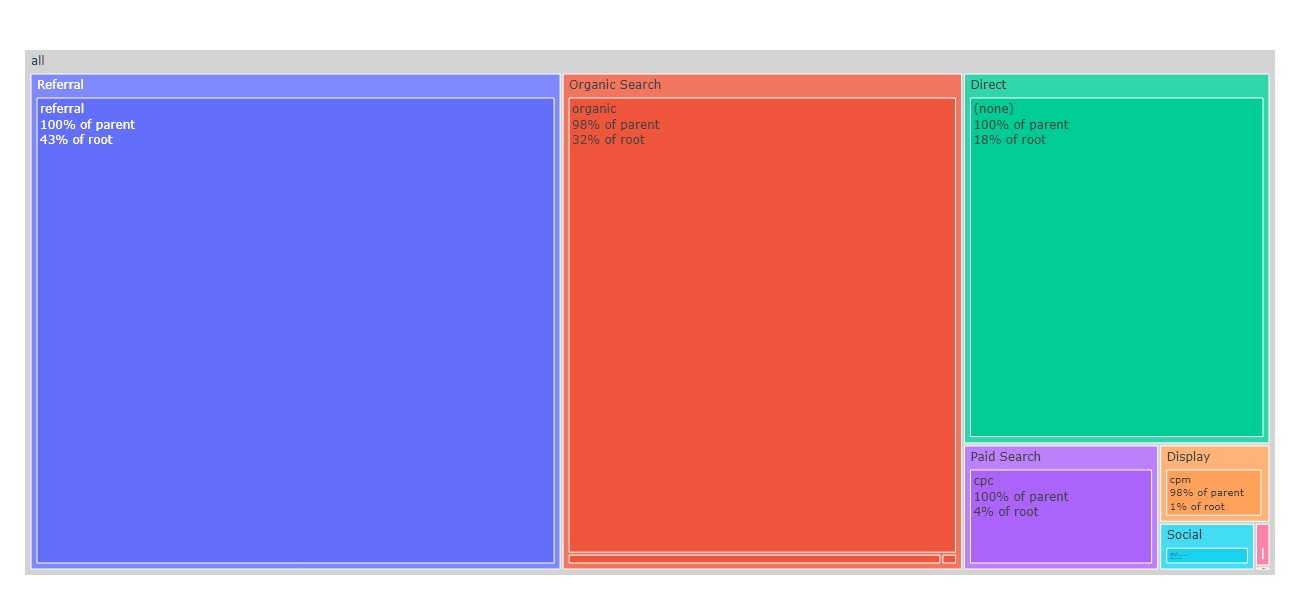

In [36]:
fig = px.treemap(X, path=[px.Constant("all"),'channelGrouping','trafficSource.medium'], 
                 values='numero_usuarios_1', width=1300, height=600)
fig.update_traces(root_color="lightgrey" ,textinfo = "label+percent parent+percent root")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Notemos que las variables son casi las mismas así que dejaremos solo channelGrouping ya que teniendo esta sabemos que es la otra.

In [37]:
X.drop(['trafficSource.medium'], axis=1, inplace=True)

# Pipeline

In [38]:
X.drop(['numero_usuarios_1'], axis=1, inplace=True)
hits = X["totals.hits"]
X.drop(['totals.hits'], axis=1, inplace=True)

In [39]:
def transforming_clustering_gmm(X,y,n_components=3, hyperparameter='full'):
    
   # Es necesario escalar la data para usar algoritmos de "clusterización"
    columns_X = X.columns
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    

    numerical_transformer = Pipeline(
    steps=[("scaler1", StandardScaler())
      ]
        )
    
    categorical_transformer =  Pipeline(steps=[
        ('encoder',TargetEncoder(smooth="auto",target_type='continuous')),
        ("scaler2", StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers =
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    gmm = GaussianMixture(n_components = n_components,max_iter=1000,n_init=15,random_state=42,covariance_type = hyperparameter) 
    
    # necesitamos "y" debido a TargetEncoder
    X_transform = preprocessor.fit_transform(X,y)
    gmm.fit(X_transform)
    df_transform = pd.DataFrame(X_transform,columns=columns_X)
    df_transform['clusters'] = gmm.predict(X_transform)
    df_transform_unscale =  X.copy()
    df_transform_unscale['clusters'] = gmm.predict(X_transform)
    return  df_transform, df_transform_unscale, gmm

In [40]:
# I try very high number of cluster but we see that it just decrease.
import time
start_time = time.time()
number_clusters = [a for a in range(2,7)]

silhoette_max = 0
index_max = -1
counter = 0
hyperparameters  = ["full","tied","diag","spherical"]
sil_dic = {}
for hyperparameter in hyperparameters :
    sil_list = []
    for clusters in number_clusters:
        df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,hits,n_components=clusters, hyperparameter=hyperparameter)
        columns_without_clusters = [x for x in df_transform.columns if x not in ['clusters']]
        silhoette = silhouette_score(df_transform[columns_without_clusters],df_transform['clusters'])
        if silhoette > silhoette_max:
            silhoette_max = silhoette
            index_max = counter 
        counter = counter + 1
        sil_list.append(silhoette)
    sil_dic[hyperparameter] = sil_list 
print(f" Seconds to run: {(time.time() - start_time)}")

 Seconds to run: 81.053147315979


In [41]:
df_sil = pd.DataFrame({
                       "cluster" :number_clusters,
                       "full":sil_dic["full"], 
                       "tied":sil_dic["tied"], 
                      "diag":sil_dic["diag"],  
                      "spherical":sil_dic["spherical"]} 
                     ) 
df_sil

,cluster,full,tied,diag,spherical
0,2,0.306188,0.370739,0.314182,0.088209
1,3,0.147955,0.209193,0.162895,0.010235
2,4,0.110210,0.213648,0.111325,-0.008866
3,5,0.107386,0.206938,0.138654,0.029191
4,6,0.135871,0.211425,0.080955,0.063307


Notamos que el mejor score es con 2 clusters y el hiperparametro tied.

In [42]:
df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X,hits,
                                                                      n_components=2,
                                                                      hyperparameter="tied")

Proporción de cada Cluster


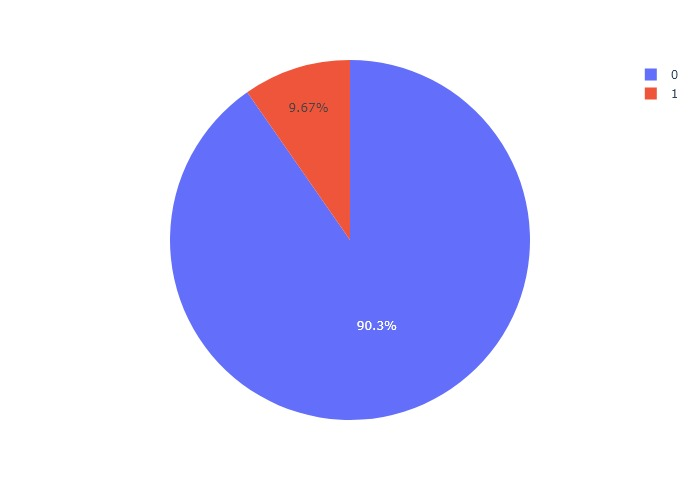

In [43]:
print("Proporción de cada Cluster")
df_transform['numero_usuarios_1'] = 1
fig = px.pie(df_transform, values='numero_usuarios_1', names='clusters')
fig.show()

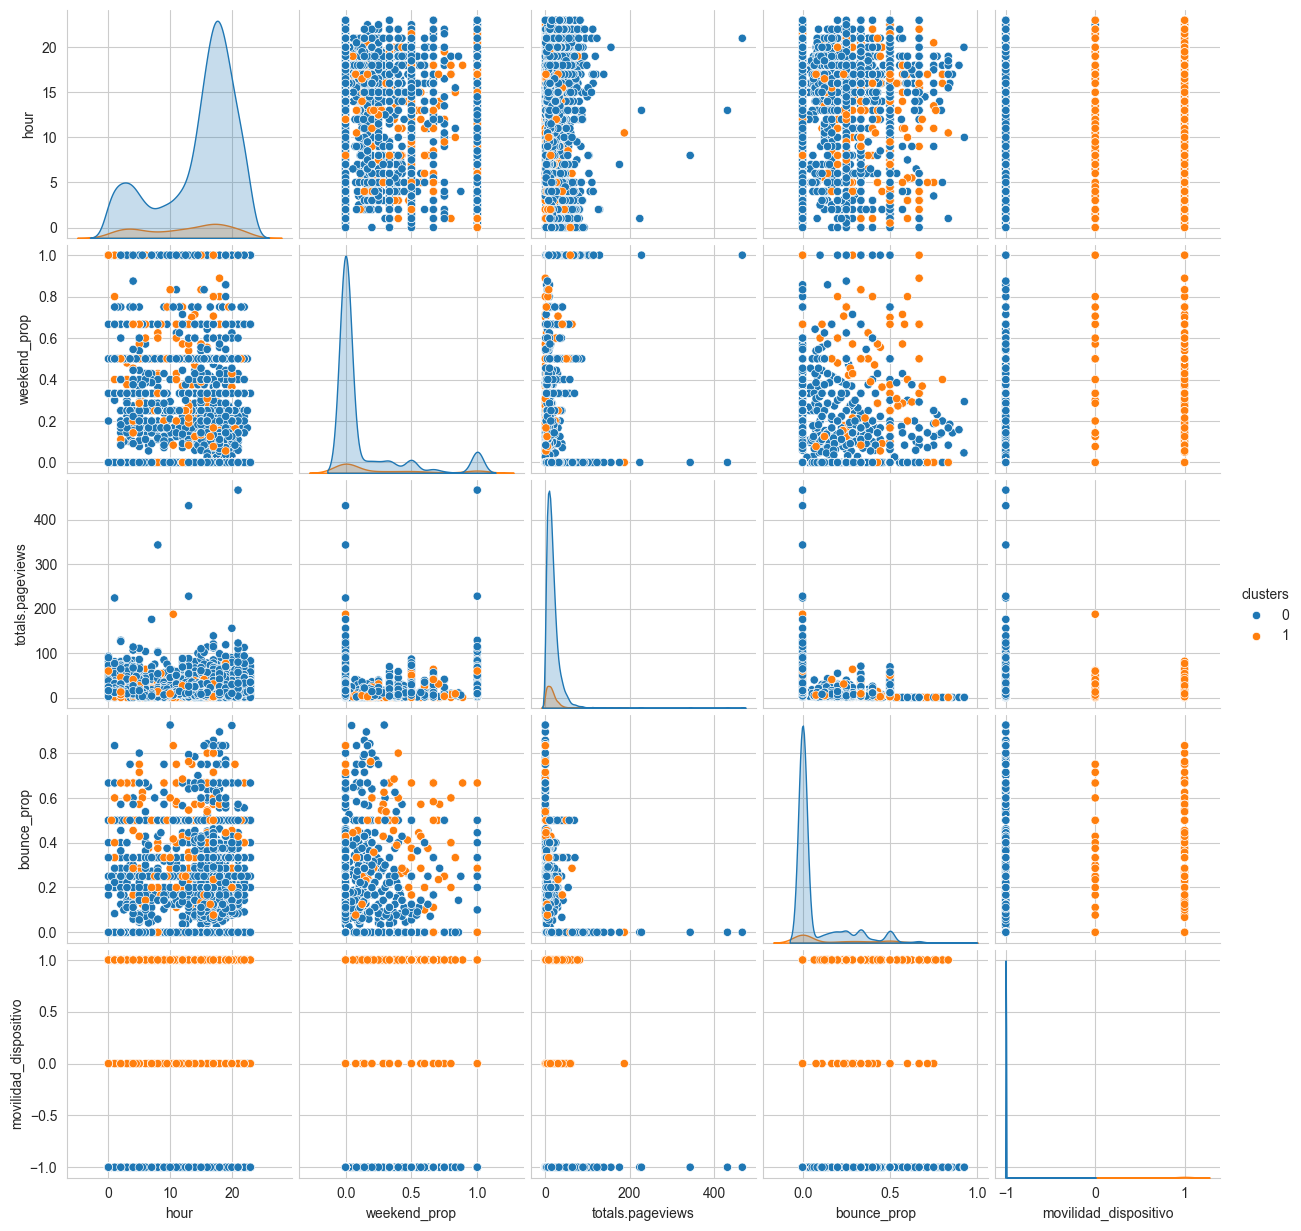

In [44]:
sns.set_style("whitegrid")
sns.color_palette("tab10")
g=sns.pairplot(df_transform_unscale,vars=['hour', 'weekend_prop', 'totals.pageviews',
                            'bounce_prop','movilidad_dispositivo'], hue='clusters')

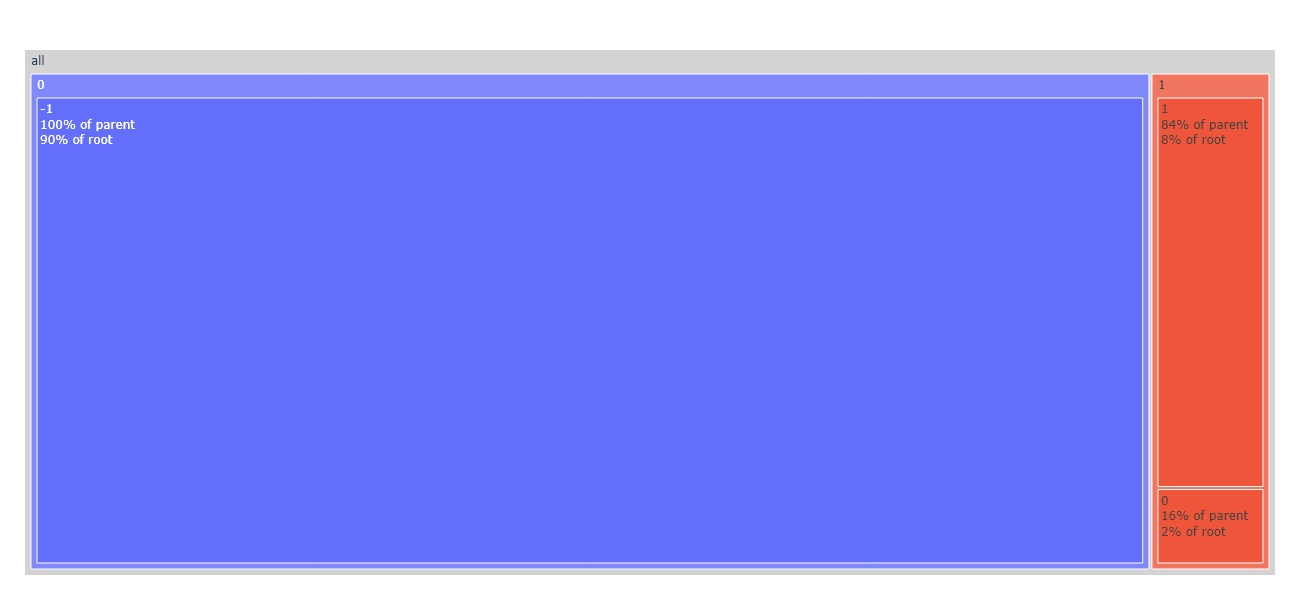

In [45]:
df_transform_unscale["numero_usuarios_1"] = 1
fig = px.treemap(df_transform_unscale, path=[px.Constant("all"),'clusters','movilidad_dispositivo'], 
                 values='numero_usuarios_1', width=1300, height=600)
fig.update_traces(root_color="lightgrey" ,textinfo = "label+percent parent+percent root")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

**Lo que sí tenemos hasta ahora:**
Notemos que el modelo genera cluster más definidos cuando la matriz de covarianza de ambos se asume es igual entre ellos (independiente de su estructura). Notemos que un k-means quedaría corto! ya que GMM con estructura esférica no separa bien estos clusters.

Notemos que hay 2 grupos que nuestro modelo clusterizo. Uno son todos los computadores y otro son todos los equipos moviles, notemos que **EL MODELO INDENTIFICO ESTOS GRUPOS POR SU CUENTA**  Este punto es impresionante a opinión de autor. 

**Temas para indagar todavía:**

Sin embargo, quedamos con un sabor semi-amargo, ya que hay tantas variables dentro de nuestra data que depende del tipo de dispositivo (tipo de movilidad, sistema operativo e incluso el browser)

Más aún quedamos con dudas. 

Ahora surgen dudas de este gráfico y temas no tratados (Los gráficos tienen utilidades pero hay que saber complementarlos con otros para contar una historia correcta).

Un punto importante es preguntarse 
¿Qué paso con las variables categoricas? 
la respuesta es cómo se uso "targetEncoding" lo que se hizo en grandes rasgos es que a cada categoría se le asigno un promedio del número de hits. Entonces cuando una de estás esta elevada, quiere decir que el grupo en cuestión pertenecia a una categoría que en promedio tenía hartas interacciones o hits. 

Otro punto, la forma que usamos GMM también podría ser critica por ser netamente matemática. Ya que podríamos hilar un poco más fino y notar que las variables pertenecen a distintos clusters:

1) Comportamiento web: hits, pageviews, bounce_prop
2) Cómo y cuando llegaron: hora, channelGrouping, trafficsource,weekend_prop
3) caracteristicas usuarios: browser, operatingSystem, movilidad_dispositivo

Un aprendizaje, que si resaltaré de nuevo. En caso de segmentar poniendo "todo en la juguera" El modelo diferencia cómo más relevante el tipo de equipo. 

crearé otros modelos, usando otras variables y usemos nuestra herramientas matemáticas de una forma que nos ayuden a "expandir nuestro conocimiento más allá de lo evidente". 

In [46]:
#df_transform

# Yendo más allá de la segmentación evidente

usaremos aquí solo las variables númericas. Ya que están tienen un mix de las 3 características de arriba. usaremos 2 del comportamiento web (pageviews y bounce_prop). Usaremos 2 que indica cuando llegaron (hora, weekend_prop) y 1 que indica movilidad (movilidad_dispositivo).

(Conozco que uno no debería repetir el código por concepto **"DRY"** Pero me permitiré esto para trabajar más rápido, de antemano perdón!)

In [47]:
variables_modelo = [ "totals.pageviews", "bounce_prop", "hour", "movilidad_dispositivo","weekend_prop"]

In [48]:
#X.columns

In [49]:
# I try very high number of cluster but we see that it just decrease.
import time
start_time = time.time()
number_clusters = [a for a in range(2,7)]

silhoette_max = 0
index_max = -1
counter = 0
hyperparameters  = ["full","tied","diag","spherical"]
sil_dic = {}
for hyperparameter in hyperparameters :
    sil_list = []
    for clusters in number_clusters:
        df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X[variables_modelo],hits,n_components=clusters, hyperparameter=hyperparameter)
        columns_without_clusters = [x for x in df_transform.columns if x not in ['clusters']]
        silhoette = silhouette_score(df_transform[columns_without_clusters],df_transform['clusters'])
        if silhoette > silhoette_max:
            silhoette_max = silhoette
            index_max = counter 
        counter = counter + 1
        sil_list.append(silhoette)
    sil_dic[hyperparameter] = sil_list 
print(f" Seconds to run: {(time.time() - start_time)}")

 Seconds to run: 64.63316702842712


In [50]:
df_sil = pd.DataFrame({
                       "cluster" :number_clusters,
                       "full":sil_dic["full"], 
                       "tied":sil_dic["tied"], 
                      "diag":sil_dic["diag"],  
                      "spherical":sil_dic["spherical"]} 
                     ) 
df_sil

,cluster,full,tied,diag,spherical
0,2,0.276838,0.459521,0.276838,0.178652
1,3,0.252836,0.352107,0.253693,0.201074
2,4,0.311937,0.391117,0.312057,0.258886
3,5,0.315018,0.405621,0.314903,0.314007
4,6,0.312651,0.392710,0.272607,0.275524


El mejor modelo sigue siendo mejor con **tied 2 cluster**. Pero estos desgraciadamente no entregan mucho valor ya que sigue separando por equipo. Entonces por el motivo de "expandir nuestro conocimiento más allá de lo evidente" usaremos el segundo mejor que es tied con 5 clusters! 

In [51]:
df_transform, df_transform_unscale, gmm = transforming_clustering_gmm(X[variables_modelo] ,hits,
                                                                      n_components=5,
                                                                      hyperparameter="tied")

Proporción de cada Cluster


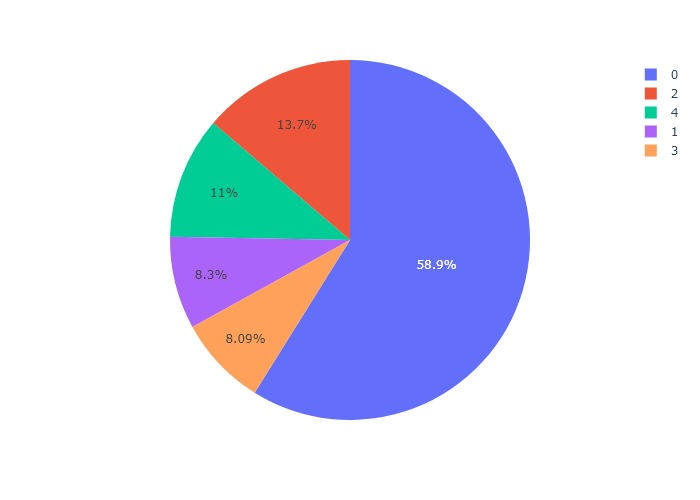

In [52]:
print("Proporción de cada Cluster")
df_transform['numero_usuarios_1'] = 1
fig = px.pie(df_transform, values='numero_usuarios_1', names='clusters')
fig.show()

In [53]:
columns_without_clusters = [x for x in df_transform_unscale.columns if x not in ['clusters']] 
def creating_dataframe_clusters_from_lists(lists,columns):
    df = pd.DataFrame(columns=columns)
    df.loc[len(df)] = lists[0]
    df['clusters'] = str("0")
    counter = 0
    for element in lists:
        if counter == 0:
            counter = counter + 1
            continue
        else:
            #print(counter)
            new_list = list(lists[counter]) + list(str(counter))
            df.loc[len(df)] = new_list
            counter = counter + 1
    return df
        

In [54]:
df_centers = creating_dataframe_clusters_from_lists(gmm.means_,columns_without_clusters)
df_centers

,totals.pageviews,bounce_prop,hour,movilidad_dispositivo,weekend_prop,clusters
0,-0.014911,-0.343620,0.455260,-0.307370,-0.349268,0
1,0.455952,-0.323897,-0.239014,-0.248921,2.606840,1
2,0.344884,-0.397305,-1.671309,-0.279840,-0.249129,2
3,-0.184051,0.514567,-0.304863,3.274349,0.353957,3
4,-0.557363,2.075266,0.150305,-0.245137,-0.170463,4


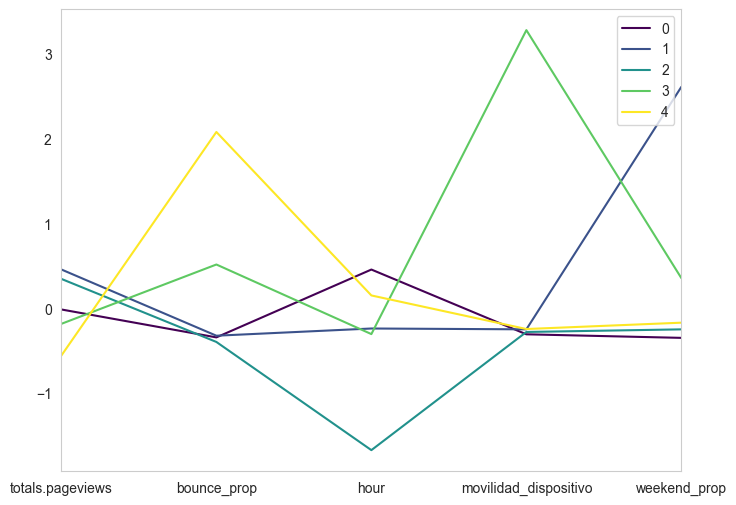

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.plotting.parallel_coordinates(
    df_centers[variables_modelo + ['clusters']] , 'clusters', colormap='viridis',use_columns= False,axvlines = False,ax=ax)

print(" ")

Este gráfico es fundamental para los gráficos de abajo!

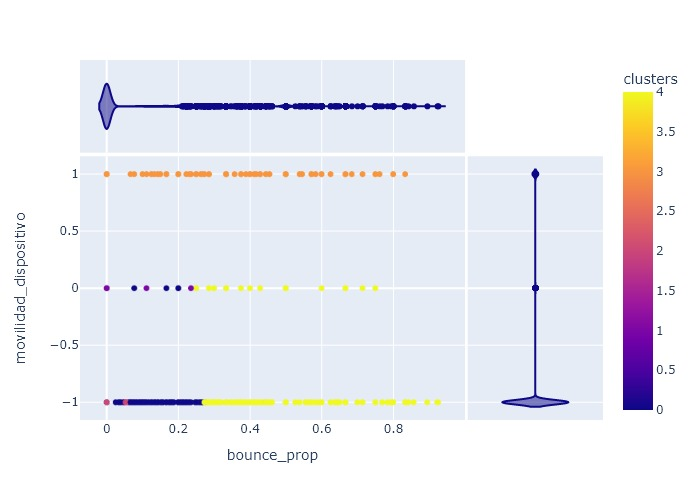

In [59]:
fig = px.scatter(df_transform_unscale, x="bounce_prop", y="movilidad_dispositivo", 
                 marginal_x="violin", marginal_y="violin",  color="clusters")
fig.show()

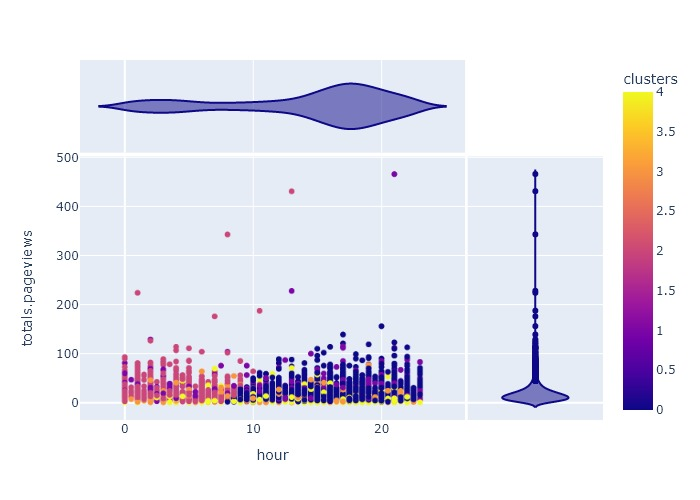

In [56]:
fig = px.scatter(df_transform_unscale, x="bounce_prop", y="totals.pageviews", 
                 marginal_x="violin", marginal_y="violin",  color="clusters")
fig.show()

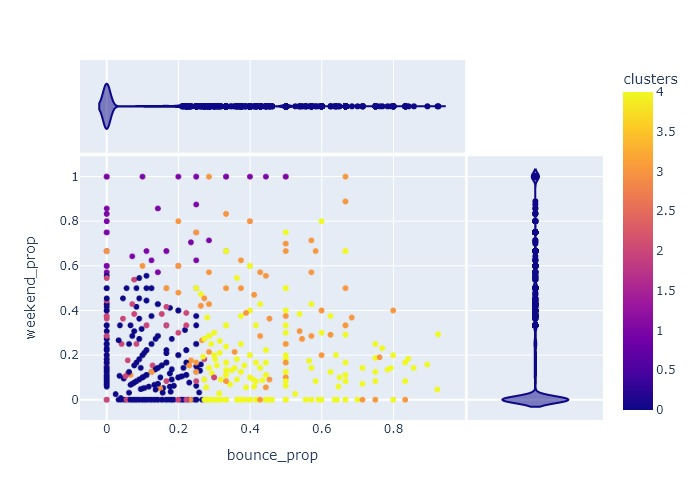

In [57]:
fig = px.scatter(df_transform_unscale, x="bounce_prop", y="weekend_prop", 
                 marginal_x="violin", marginal_y="violin",  color="clusters")
fig.show()

Pongamosle nombre a los clusters!

0) Estos usuarios navegan de noche y tienen baja tasa de rebote. **Night Owl**
1) Usuarios que navegan mucho los fin de semanas. **Binge weekend**
2) Navegan temprano y bastante por el sitio web **Early binge**
3) Este es el grupo de clientes que usan celulares. El modelo automaticamente dejo un cluster solo para clientes que usan el celular. **Usuarios de moviles**
4) Estos usuarios tienen la mayor tasa de rebote y también son los que menos revisan nuestro sitio web. **Upsi, Me equivoque de sitio** 

Recomendaciones de Marketing

Es importante entender que extraer insight con valores numéricos desprovistos del negocio es quizás 
imposible. Por ejemplo, ¿qué constituye un buen viaje del cliente por la plataforma? Es necesario que el 
cliente navegue harto por el sitio web visitando hartas páginas e interactuando mucho para que sea una 
buena experiencia, o es todo lo contrario, navegación corta llegando directo donde quiere y realizando 
esto con éxito. Estos datos se tienen sin la parte fundamental del negocio, por ende las recomendaciones 
serán simples, pese a que el análisis matemático no lo fue.

**Night Owl**

Descripción: Usuarios que navegan de noche y tienen baja tasa de rebote.
• Ofertas Nocturnas: Implementar promociones y descuentos exclusivos durante las horas 
nocturnas para incentivar compras.

• Contenido Personalizado: Enviar notificaciones y correos electrónicos con contenido relevante 
durante las horas en que estos usuarios están activos.

• Eventos en Vivo: Organizar eventos en vivo o transmisiones nocturnas que puedan atraer a 
estos usuarios.

• Tener Dark mode: Esto es para una optima experiencia.

**Binge Weekend**

Descripción: Usuarios que navegan mucho los fines de semana.

• Promociones de Fin de Semana: Ofrecer descuentos especiales y promociones limitadas a los 
fines de semana.

• Contenido de Entretenimiento: Crear contenido atractivo y entretenido que mantenga a estos 
usuarios comprometidos durante sus sesiones de navegación.

• Campañas de Email: Enviar boletines informativos y promociones específicas los viernes para 
preparar a estos usuarios para el fin de semana.

**Early Binge**

Descripción: Usuarios que navegan temprano y bastante por el sitio web.

• Ofertas Matutinas: Implementar promociones y descuentos exclusivos durante las horas de la 
mañana.

• Contenido Informativo: Proveer artículos, blogs y noticias que puedan ser de interés para estos 
usuarios durante sus primeras horas del día.

• Notificaciones Tempranas: Enviar correos electrónicos con ofertas y novedades temprano en la 
mañana.

**Usuarios de Móviles**

Descripción: Clientes que usan principalmente dispositivos móviles.

• Optimización Móvil: Asegurarse de que el sitio web y las campañas de marketing estén 
completamente optimizados para dispositivos móviles.

• Aplicaciones Móviles: Promover el uso de aplicaciones móviles con características exclusivas 
y notificaciones push.

• Ofertas Geolocalizadas: Utilizar la geolocalización para enviar ofertas y promociones basadas 
en la ubicación del usuario.

**Upsi, Me Equivoqué de Sitio**

Descripción: Usuarios con la mayor tasa de rebote y que menos revisan el sitio web.

• Mejora de la Experiencia de Usuario: Analizar y mejorar la experiencia de usuario en el sitio 
web para reducir la tasa de rebote.

• Contenido Atractivo: Crear contenido más atractivo y relevante para captar la atención de 
estos usuarios.

• Campañas de Retargeting: Implementar campañas de retargeting para atraer nuevamente a 
estos usuarios y ofrecerles incentivos para que regresen